In [4]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from itertools import permutations
from scipy.stats import linregress

In [5]:
def generate_random_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        a, b = random.uniform(-1, 1), random.uniform(-1, 1)
        c, d = random.uniform(-1, 1), random.uniform(-1, 1)
        e, f = random.uniform(-1, 1), random.uniform(-1, 1)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())

    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities

def generate_self_similar_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        scale = random.uniform(0.2, 0.7)
        # scale = random.uniform(0.2, 0.5)
        angle = random.uniform(0, 2 * math.pi)

        a = scale * math.cos(angle)
        b = -scale * math.sin(angle)
        c = scale * math.sin(angle)
        d = scale * math.cos(angle)

        e = random.uniform(-1, 1)
        f = random.uniform(-1, 1)
        # e = random.uniform(-0.3, 0.3)
        # f = random.uniform(-0.3, 0.3)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities


def apply_transform(x, y, transform):
    a, b, c, d, e, f = transform
    new_x = a * x + b * y + e
    new_y = c * x + d * y + f
    return new_x, new_y

def generate_fractal(transformations, probabilities, n_points=100000):
    """Generate fractal points using an IFS."""
    x, y = 0, 0
    points = []

    for _ in range(n_points):
        transform = random.choices(transformations, weights=probabilities, k=1)[0]
        x, y = apply_transform(x, y, transform)
        points.append((x, y))

    return points


In [6]:
def box_count_2d(points, eps):
    x_coords, y_coords = points[:, 0], points[:, 1]

    Nx = int(np.ceil(1.0 / eps))
    Ny = int(np.ceil(1.0 / eps))

    occupancy = np.zeros((Nx, Ny), dtype=bool)

    for x, y in zip(x_coords, y_coords):
        ix = int(x // eps)
        iy = int(y // eps)
        if ix >= Nx: 
            ix = Nx - 1
        if iy >= Ny: 
            iy = Ny - 1
        occupancy[ix, iy] = True

    return np.sum(occupancy)


def compute_box_dimension_2d(points, epsilons, skip_extremes=0):
    counts = []
    for eps in epsilons:
        N = box_count_2d(points, eps)
        counts.append(N if N > 0 else 1)

    logs = np.log(1 / np.array(epsilons))
    log_counts = np.log(counts)

    if skip_extremes > 0:
        if 2 * skip_extremes < len(epsilons):
            logs_for_regression = logs[skip_extremes:-skip_extremes]
            log_counts_for_regression = log_counts[skip_extremes:-skip_extremes]
        else:
            logs_for_regression = logs
            log_counts_for_regression = log_counts
    else:
        logs_for_regression = logs
        log_counts_for_regression = log_counts

    slope, intercept, r_value, p_value, std_err = linregress(logs_for_regression, log_counts_for_regression)

    return slope, intercept, r_value, p_value, std_err, logs, log_counts

def normalize_to_unit_square(points):
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)

    min_x, max_x = np.min(x_coords), np.max(x_coords)
    min_y, max_y = np.min(y_coords), np.max(y_coords)

    width = max_x - min_x
    height = max_y - min_y

    if width == 0: 
        width = 1e-12
    if height == 0: 
        height = 1e-12

    norm_x = (x_coords - min_x) / width
    norm_y = (y_coords - min_y) / height

    return np.column_stack((norm_x, norm_y))

def show_results(transformations, probabilities, epsilons=None, n_points=10000000, skip_extremes=2):
    raw_points = generate_fractal(transformations, probabilities, n_points=n_points)
    norm_points = normalize_to_unit_square(raw_points)

    x_coords, y_coords = zip(*raw_points)
    plt.figure(figsize=(5,5))
    plt.scatter(x_coords, y_coords, s=0.1, color="black")
    plt.axis("off")
    plt.title("Fractal Generated by IFS")
    plt.show()

    if epsilons is None:
        epsilons = [2**(-i) for i in range(1, 13)]

    slope, intercept, _, _, _, logs, log_counts = compute_box_dimension_2d(
        norm_points,
        epsilons,
        skip_extremes=skip_extremes
    )
    print(f"Box-counting dimension: {slope:.4f}")

    plt.figure(figsize=(6,4))
    plt.scatter(logs, log_counts, color='blue', label='Data points')

    slope_line = slope * logs + intercept
    plt.plot(logs, slope_line, color='red', 
             label=f'Regression: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('log(1/epsilon)')
    plt.ylabel('log(N(epsilon))')
    plt.legend()
    plt.title('Regression (Box Counting Dimension)')
    plt.legend()
    plt.show()

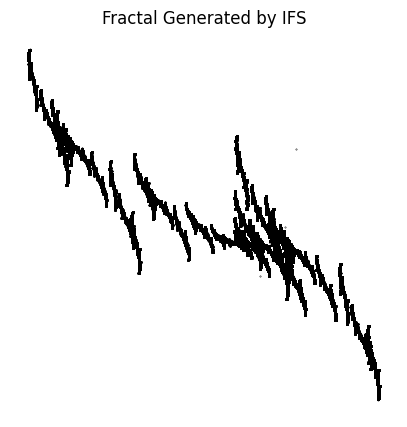

Box-counting dimension: 1.3711


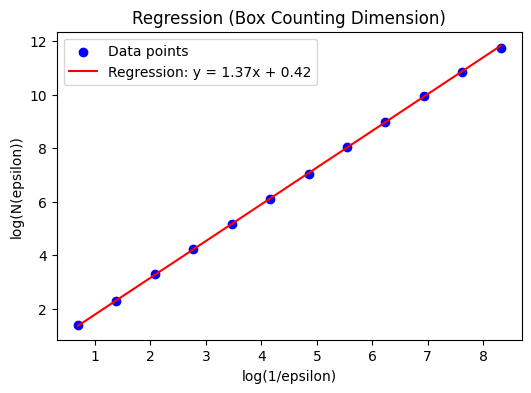

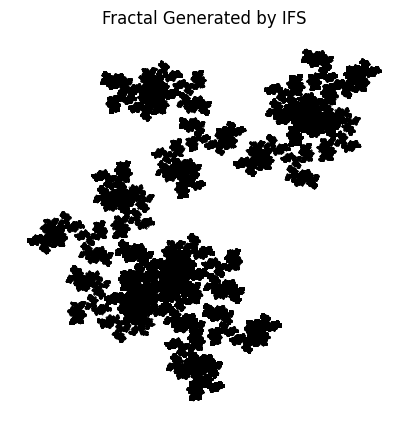

Box-counting dimension: 1.6483


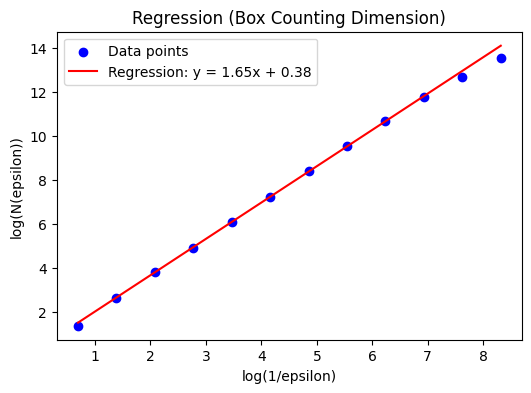

In [5]:
n_transforms = 3
for i in range(1,3):
    transformations, probabilities = generate_self_similar_ifs(n_transforms)
    show_results(transformations, probabilities)

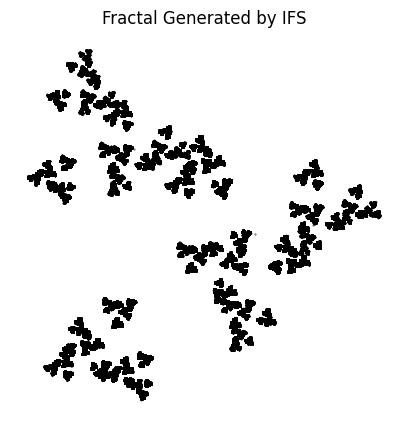

Box-counting dimension: 1.3765


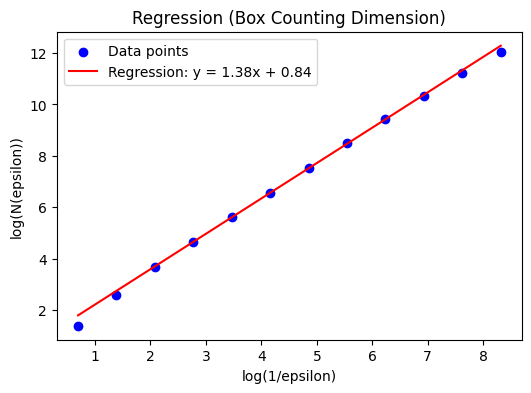

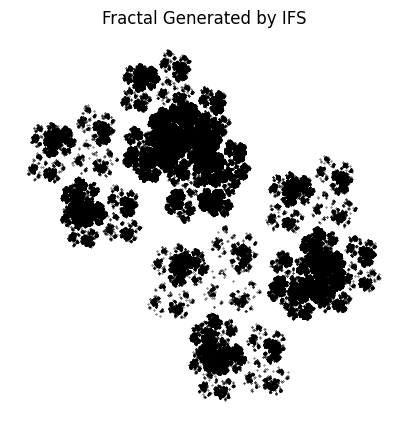

Box-counting dimension: 1.5759


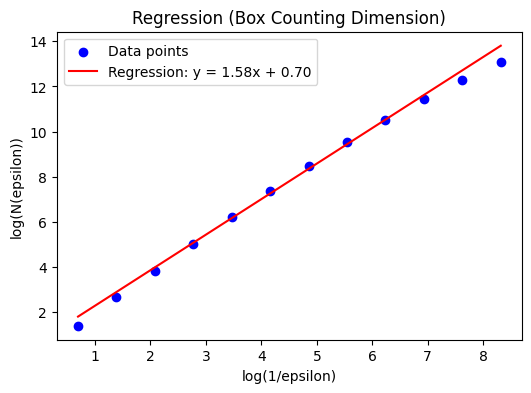

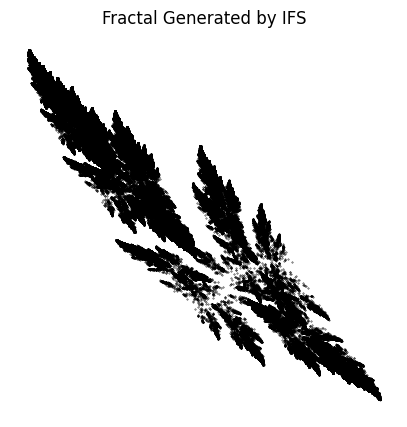

Box-counting dimension: 1.6456


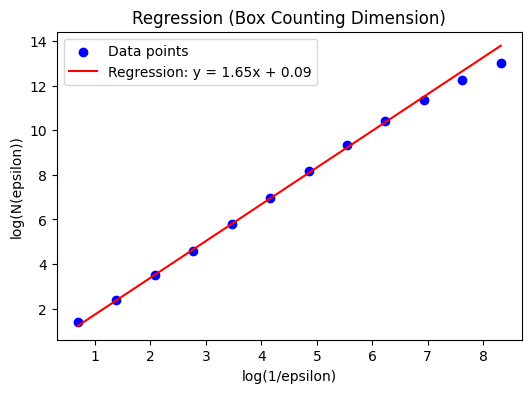

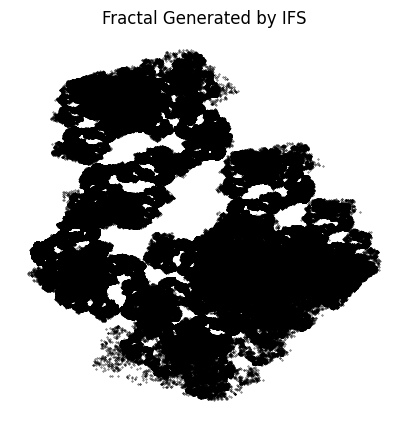

Box-counting dimension: 1.8227


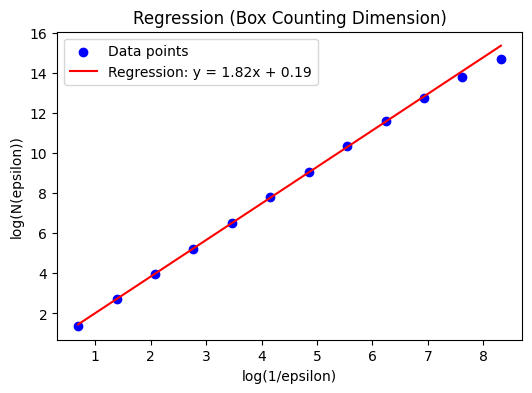

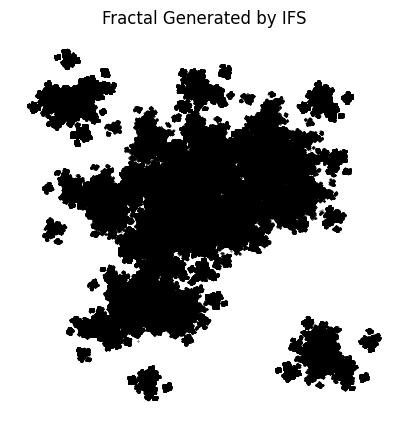

Box-counting dimension: 1.7669


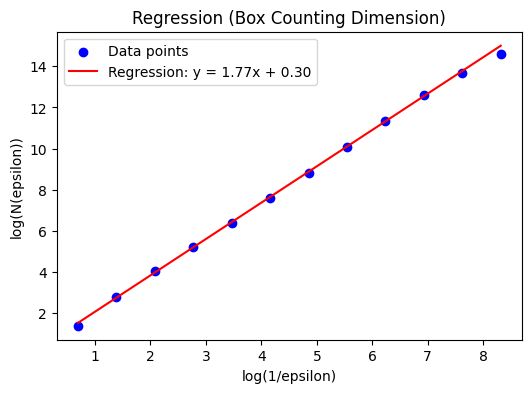

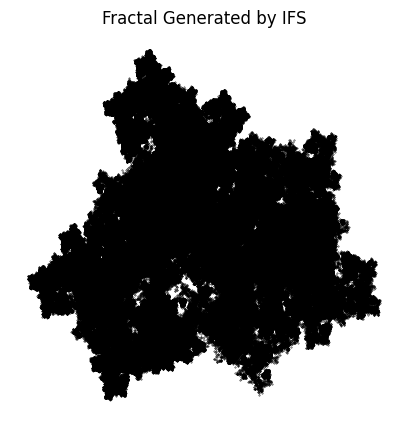

Box-counting dimension: 1.8706


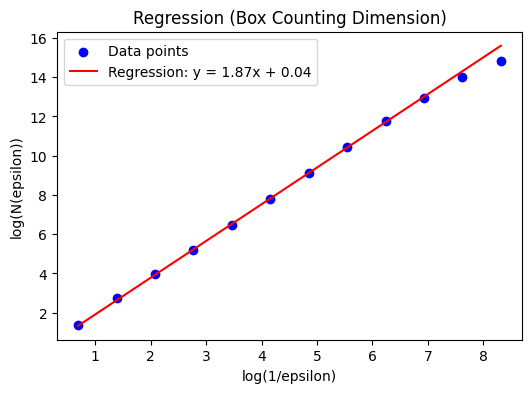

In [6]:
for i in range(3,9):
    transformations, probabilities = generate_self_similar_ifs(i)
    show_results(transformations, probabilities)

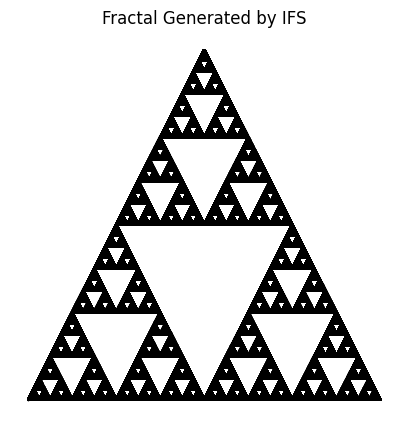

Box-counting dimension: 1.5806


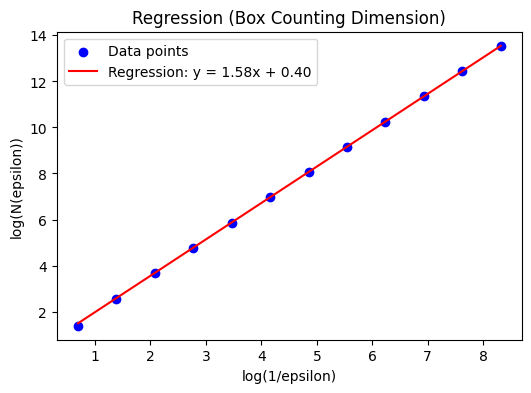

In [7]:
#SIERPINSKI'S TRIANGLE
#expected dim = 1.585
transformations = [
    (0.5, 0.0, 0.0, 0.5, 0.0, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.5, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.25, 0.433),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

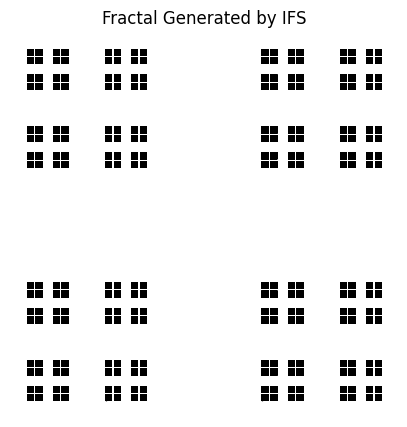

Box-counting dimension: 1.3452


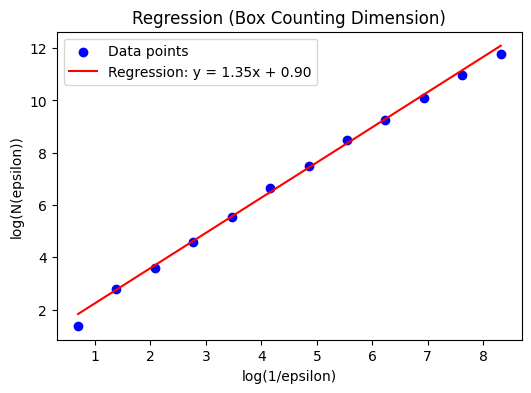

In [8]:
# CANTOR DUST
# Expected dim = 1.26186
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

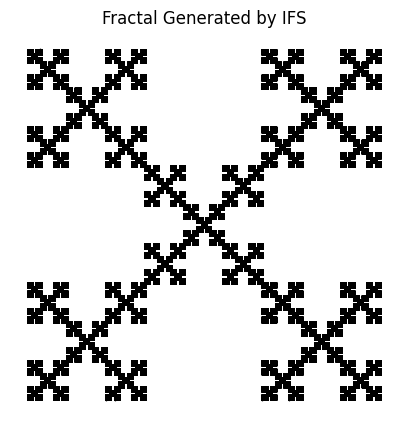

Box-counting dimension: 1.5090


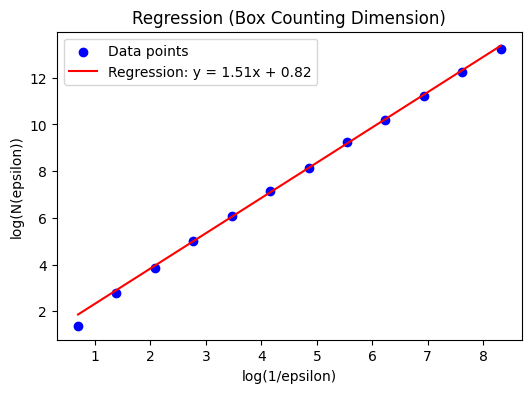

In [9]:
# VICSEK FRACTAL
# Expected dim = log(5)/log(3) = 1.465
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 1/3, 1/3),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

Modyfikacje fraktali klasycznych z losowością

In [10]:
def generate_sierpinski_triangle_mod_ifs(scale_range=(0.3, 0.7), shift_range=0.5):
    scale1 = random.uniform(scale_range[0], scale_range[1])
    shift_x1 = random.uniform(-shift_range, shift_range)
    shift_y1 = random.uniform(-shift_range, shift_range)
    T1 = (
        scale1, 0.0,
        0.0,    scale1,
        shift_x1, shift_y1
    )
    
    scale2 = random.uniform(scale_range[0], scale_range[1])
    shift_x2 = 0.5 + random.uniform(-shift_range, shift_range)
    shift_y2 = 0.0 + random.uniform(-shift_range, shift_range)
    T2 = (
        scale2, 0.0,
        0.0,    scale2,
        shift_x2, shift_y2
    )
    
    scale3 = random.uniform(scale_range[0], scale_range[1])
    shift_x3 = 0.25 + random.uniform(-shift_range, shift_range)
    shift_y3 = (math.sqrt(3)/4) + random.uniform(-shift_range, shift_range)
    T3 = (
        scale3, 0.0,
        0.0,    scale3,
        shift_x3, shift_y3
    )
    
    transformations = [T1, T2, T3]
    probabilities = [1/3, 1/3, 1/3]

    return transformations, probabilities


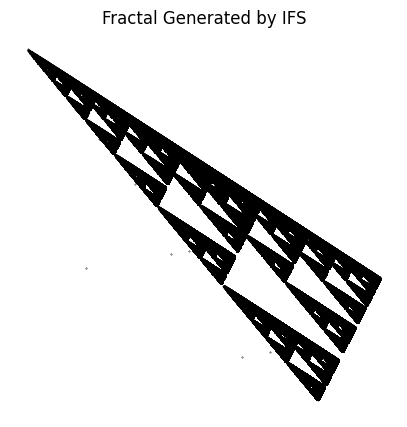

Box-counting dimension: 1.6327


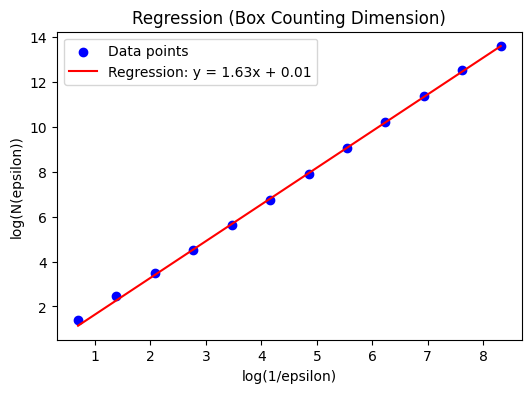

In [11]:
transformations, probabilities = generate_sierpinski_triangle_mod_ifs()
show_results(transformations, probabilities)

In [12]:
def generate_sierpinski_carpet_mod_ifs(scale_range=(0.2, 0.4), shift_range=0.2):
    transformations = []
    
    for dx in range(3):
        for dy in range(3):
            if dx == 1 and dy == 1:
                continue
            
            a = random.uniform(scale_range[0], scale_range[1])
            d = a
            b = 0
            c = 0

            base_x = dx/3
            base_y = dy/3

            shift_x = random.uniform(-shift_range, shift_range)
            shift_y = random.uniform(-shift_range, shift_range)

            e = base_x + shift_x
            f = base_y + shift_y

            transformations.append((a, b, c, d, e, f))

    probabilities = [1/8]*len(transformations)

    return transformations, probabilities


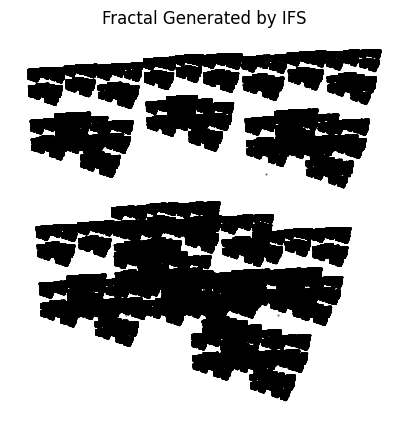

Box-counting dimension: 1.7789


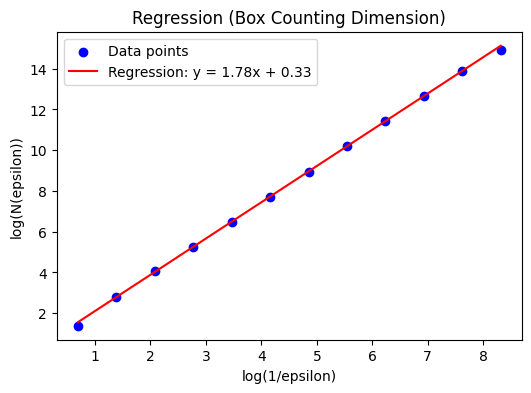

In [13]:
transformations, probabilities = generate_sierpinski_carpet_mod_ifs()
show_results(transformations, probabilities)

Poniższy kod zawiera modyfikację algorytmu generującą Trójkąt Sierpińskiego. Zamiast usuwać środkowy trójkąt, zostaje usunięty trójkąt "górny" względem perspektywy trójkąta. Warto zauważyć, że jesteśmy w stanie taki algorytm zaimplementować na 3! = 6 sposobów (liczba permutacji wierzchołków środkowego trójkąta), co zostało zrandomizowane - za każdym razem ustawienie trójkąta (więc i trójkąt który będziemy usuwać) jest losowane z dostępnej puli permutacji. Zmieniając parametr "randomize" można włączyć lub wyłączyć tą losową modyfikację.

In [24]:
def sample_triangle(points, num_samples=50):
    (x1, y1), (x2, y2), (x3, y3) = points
    sampled_points = []
    for _ in range(num_samples):
        u, v = random.random(), random.random()
        if u + v > 1:
            u, v = 1 - u, 1 - v
        x = x1 + (x2 - x1)*u + (x3 - x1)*v
        y = y1 + (y2 - y1)*u + (y3 - y1)*v
        sampled_points.append((x, y))
    return sampled_points

def sierpinski_mod_rand(points, n, randomize, num_samples=50):
    if n == 0:
        return sample_triangle(points, num_samples=num_samples)
    
    mid1 = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
    mid2 = ((points[1][0] + points[2][0]) / 2, (points[1][1] + points[2][1]) / 2)
    mid3 = ((points[0][0] + points[2][0]) / 2, (points[0][1] + points[2][1]) / 2)

    perm = permutations([mid1, mid2, mid3]) 
    
    sub_points = []
    sub_points.extend(sierpinski_mod_rand([points[0], mid1, mid3], n - 1, randomize, num_samples))
    sub_points.extend(sierpinski_mod_rand([points[1], mid1, mid2], n - 1, randomize, num_samples))

    if randomize:
        random_perm = random.choice(list(perm))
        sub_points.extend(sierpinski_mod_rand(random_perm, n - 1, randomize, num_samples))
    else:
        sub_points.extend(sierpinski_mod_rand([points[2], mid2, mid3], n - 1, randomize, num_samples))
    return sub_points

def draw_sierpinski_mod_rand(n, randomize, num_samples=50):
    points = sierpinski_mod_rand(
        [(0, 0), (1, 0), (0.5, np.sqrt(3)/2)],
        n=n,
        randomize=randomize,
        num_samples=num_samples
    )
    points = np.array(points)

    plt.figure(figsize=(6,6))
    plt.scatter(points[:, 0], points[:, 1], s=0.5, color='green')
    plt.axis('equal')
    plt.axis('off')
    if randomize:
        title = f"Random Sierpiński Triangle (iterations={n})"
    else:
        title = f"Sierpiński Triangle (iterations={n})"
    plt.title(title)
    plt.show()

    return points

In [3]:
def show_results_2d(raw_points, epsilons, skip_extremes=2):    
    norm_points = normalize_to_unit_square(raw_points)
    if epsilons is None:
        epsilons = [2**(-i) for i in range(1, 13)]

    slope, intercept, r_value, p_value, std_err, logs, log_counts = compute_box_dimension_2d(
        norm_points,
        epsilons,
        skip_extremes=skip_extremes
    )
    print(f"Box-counting dimension: {slope:.4f}")

    plt.figure(figsize=(6,4))
    plt.scatter(logs, log_counts, color='blue', label='All points')
    
    slope_line = slope * logs + intercept
    plt.plot(logs, slope_line, color='red', 
             label=f'Regression: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('log(1/epsilon)')
    plt.ylabel('log(N(epsilon))')
    plt.legend()
    plt.title('Regression (Box Counting Dimension)')
    plt.legend()
    plt.show()

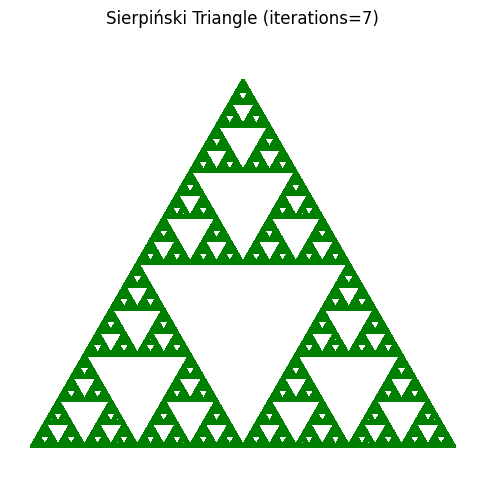

Box-counting dimension: 1.5899


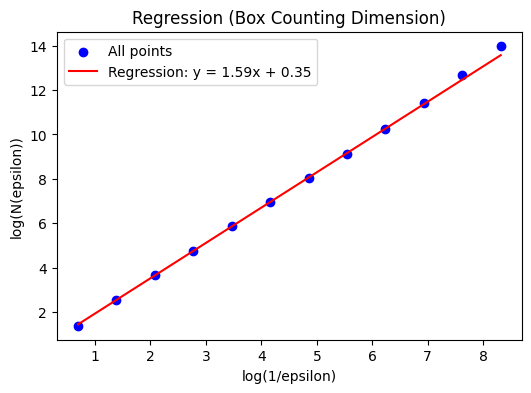

In [34]:
#SIERPINSKI'S TRIANGLE
#expected dim = 1.585
for iterations in [7]:
    num_points=10000000
    pts = draw_sierpinski_mod_rand(iterations, False, math.ceil(num_points/math.pow(3,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

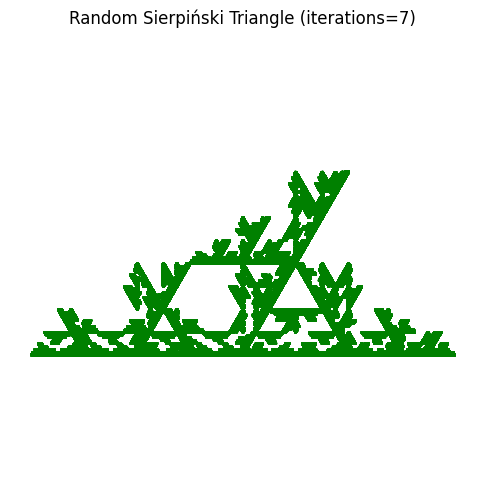

Box-counting dimension: 1.6945


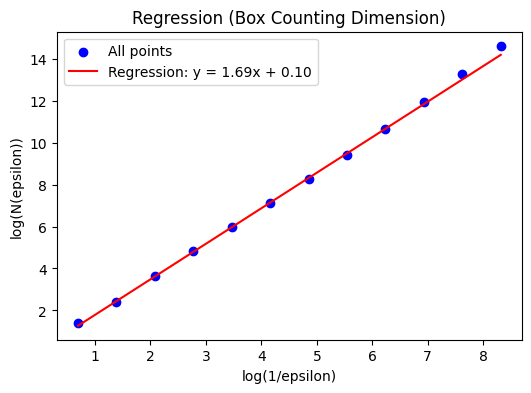

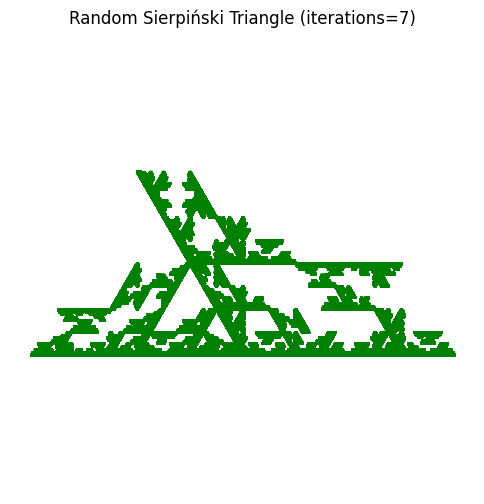

Box-counting dimension: 1.6875


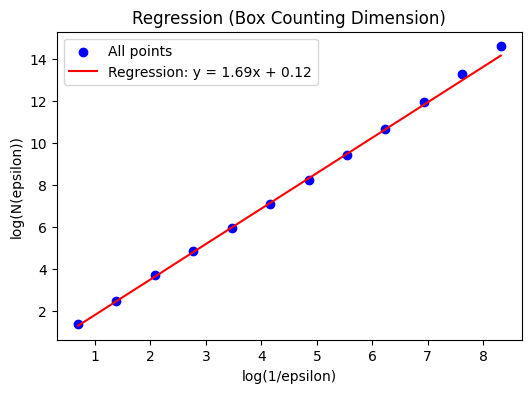

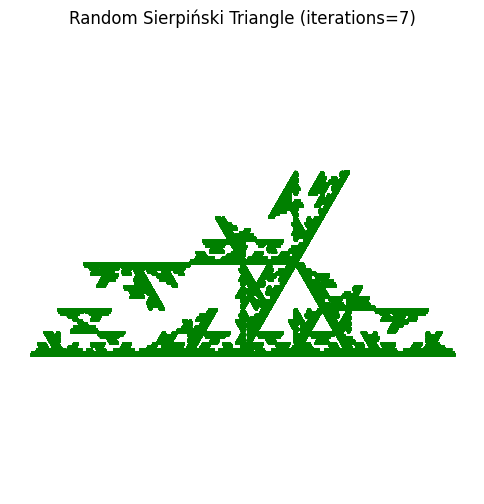

Box-counting dimension: 1.6789


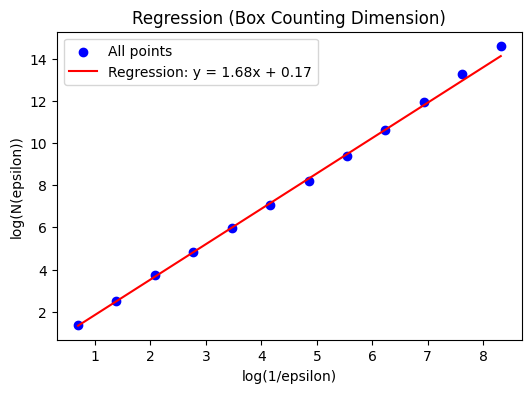

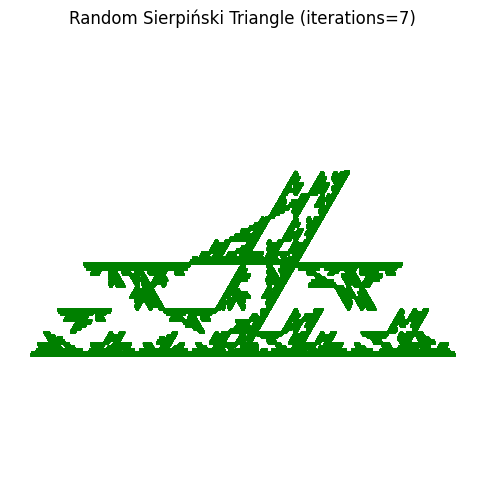

Box-counting dimension: 1.7011


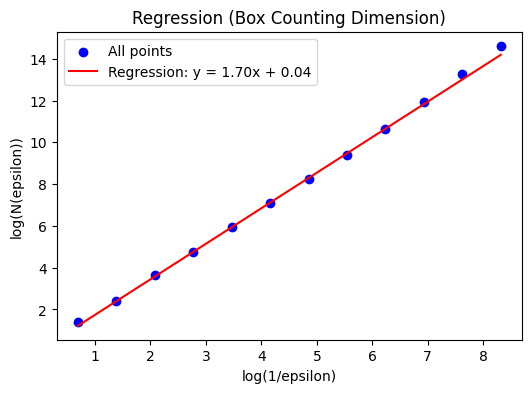

In [35]:
for i in range(1, 5):
    iterations = 7
    num_points=10000000
    pts = draw_sierpinski_mod_rand(iterations, True, math.ceil(num_points/math.pow(3,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

W poniższym kodzie klasyczny algorytm dywanu Sierpińskiego został zmodyfikowany tak, aby umożliwić wybór, które kwadraty zostaną zachowane, a które usunięte w kolejnych iteracjach. Modyfikacja ta wprowadza nową zmienną "keep_pattern", która pozwala użytkownikowi dostosować wzorzec zachowania lub usunięcia poszczególnych kwadratów w siatce 3x3. Zmienna "keep_pattern" będąca binarną reprezentacją pól kwadratu 3x3 (9 bitów) jest za każdym razem losowana (wartość dziesiętna od 0 do 511).
Parametr "randomize" odpowiada za włączenie lub wyłączenie tej losowej modyfikacji.
Parametr "delete_only_one" odpowiada za to, czy usuwany w każdej iteracji będzie tylko 1 kwadrat (ograniczenie zmiennej "keep_pattern" do 9 cyfrowych liczb binarnych, gdzie występuje 8 jedynek i jedno 0), czy dowolna ilość od 0 do 9.

In [1]:
def sample_square(x, y, side_length, num_samples=50):
    points = []
    for _ in range(num_samples):
        px = random.uniform(x, x + side_length)
        py = random.uniform(y, y + side_length)
        points.append((px, py))
    return points

def sierpinski_carpet_mod_rand_points(x, y, side_length, n, randomize, delete_only_one, num_samples=50):
    if n == 0:
        return sample_square(x, y, side_length, num_samples)
    
    new_side_length = side_length / 3
    points_list = []
    if randomize:
        if delete_only_one:
            keep_pattern = random.choice([255, 383, 447, 479, 495, 503, 507, 509, 510])
        else:
            keep_pattern = random.randint(0, 511)
    else:
        keep_pattern = 495

    for dx in range(3):
        for dy in range(3):
            square_index = dy * 3 + dx
            if not (keep_pattern & (1 << square_index)):
                continue
            
            new_x = x + dx * new_side_length
            new_y = y + dy * new_side_length
            points_sub = sierpinski_carpet_mod_rand_points(
                new_x, new_y,
                new_side_length,
                n - 1,
                randomize,
                delete_only_one,
                num_samples
            )
            points_list.extend(points_sub)
    
    return points_list

def draw_sierpinski_carpet_mod_rand_points(n, randomize=True, delete_only_one=False, num_samples=50):
    points = sierpinski_carpet_mod_rand_points(0, 0, 1, n, randomize, delete_only_one, num_samples=num_samples)
    points = np.array(points)

    plt.figure(figsize=(6,6))
    plt.scatter(points[:, 0], points[:, 1], s=0.5, color='green')
    plt.axis('equal')
    plt.axis('off')
    if randomize:
        if delete_only_one:
            title = f"Random Sierpinski Carpet (iterations={n}, delete_only_one=True)"
        else:
            title = f"Random Sierpinski Carpet (iterations={n}, delete_only_one=False)"
    else:
        title = f"Sierpinski Carpet (iterations={n})"
    plt.title(title)
    plt.show()

    return points

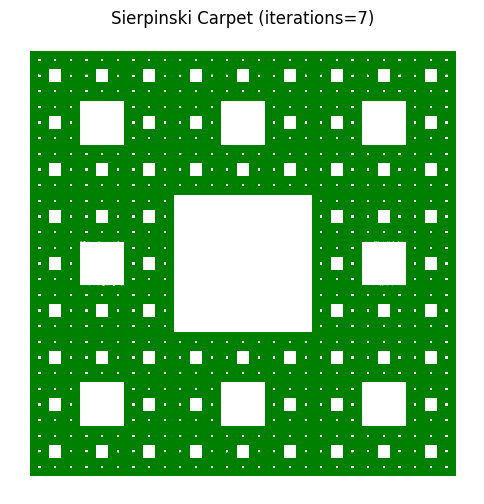

Box-counting dimension: 1.9027


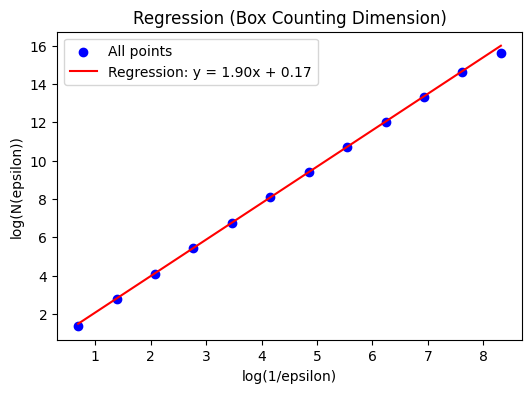

In [37]:
#SIERPINSKI'S TRIANGLE
#expected dim = 1.8928
for iterations in [7]:
    num_points=10000000
    pts = draw_sierpinski_carpet_mod_rand_points(iterations, False, False, math.ceil(num_points/math.pow(8,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

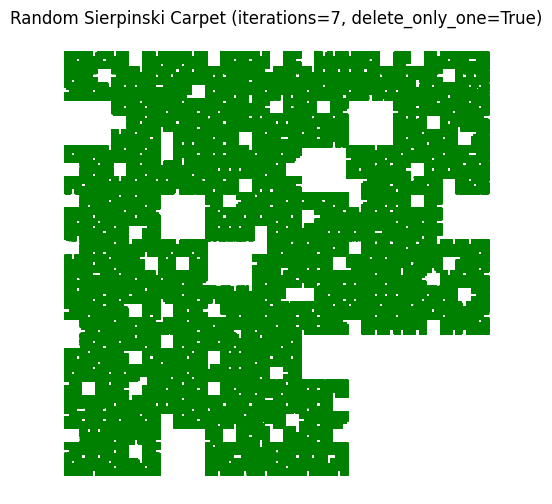

Box-counting dimension: 1.9019


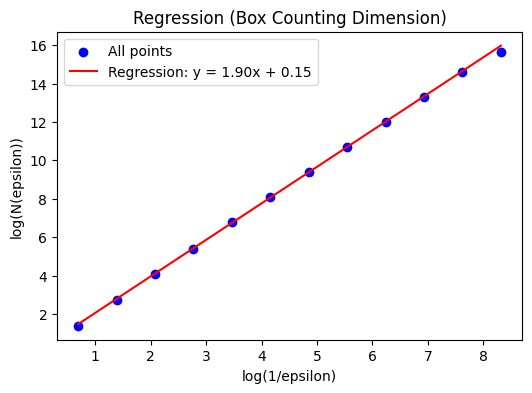

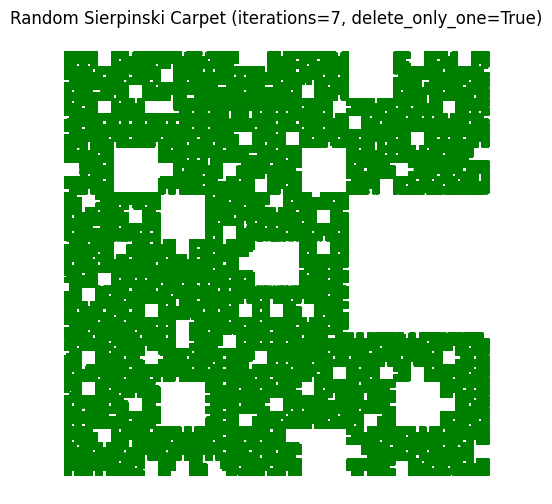

Box-counting dimension: 1.8994


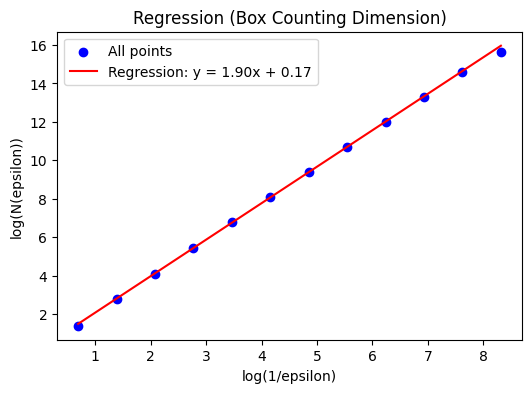

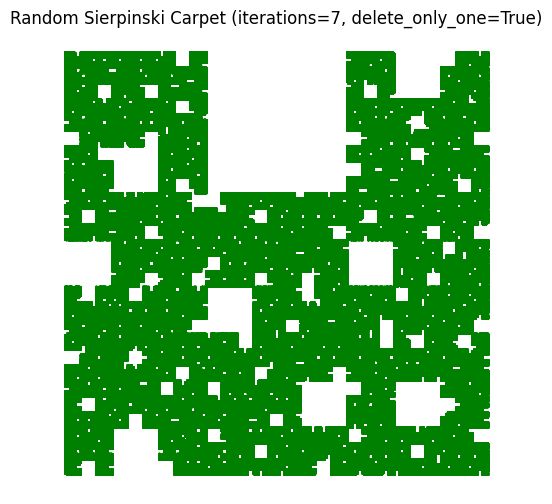

Box-counting dimension: 1.8998


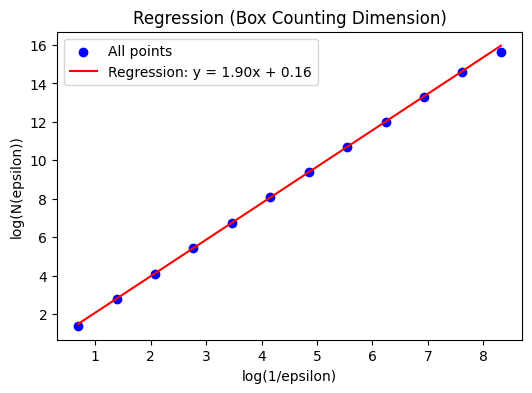

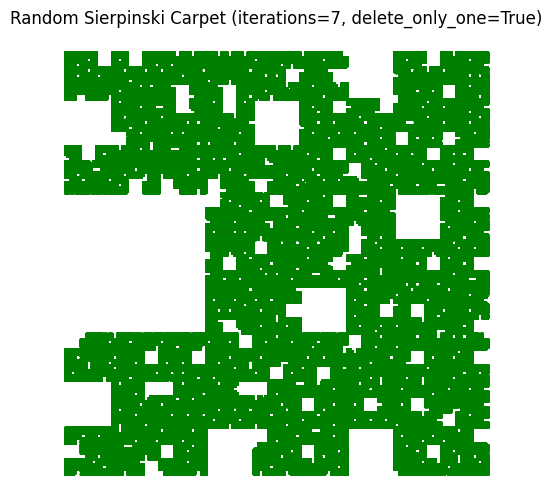

Box-counting dimension: 1.9003


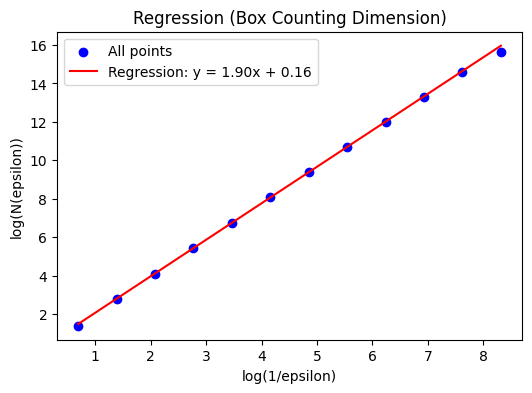

In [38]:
for i in range(1, 5):
    iterations = 7
    num_points=10000000
    pts = draw_sierpinski_carpet_mod_rand_points(iterations, True, True, math.ceil(num_points/math.pow(8,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

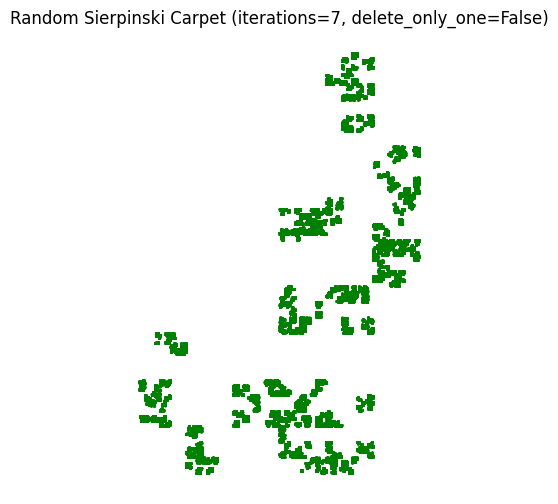

Box-counting dimension: 1.3787


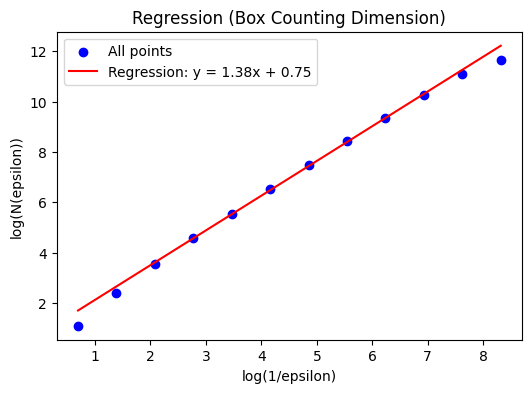

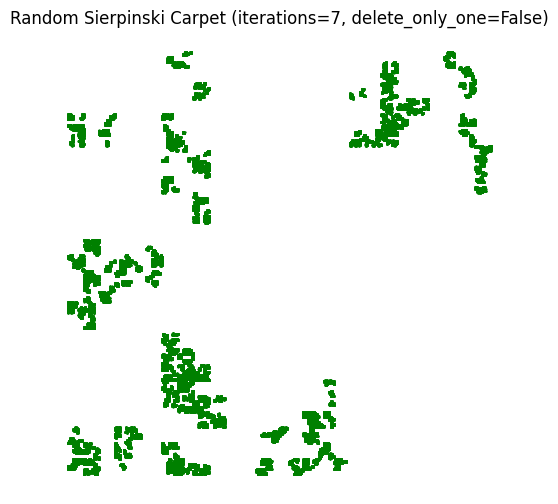

Box-counting dimension: 1.3728


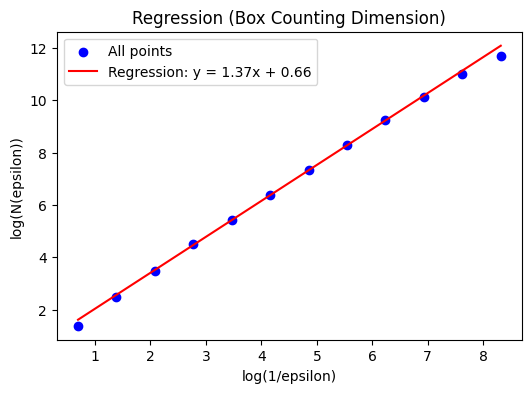

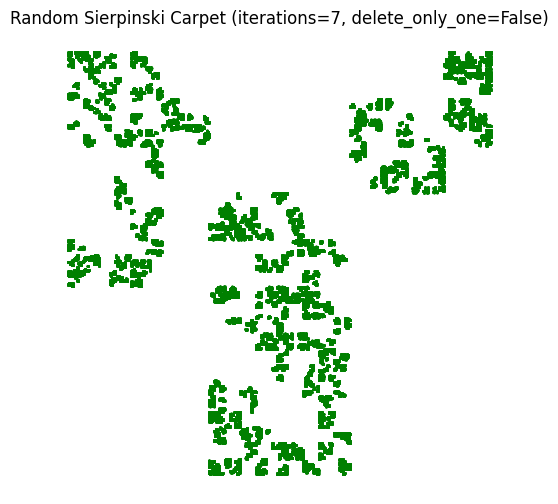

Box-counting dimension: 1.3916


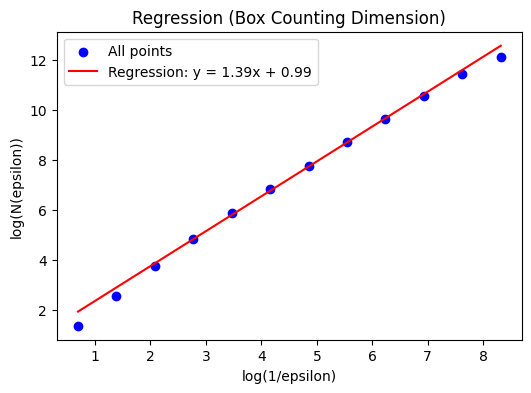

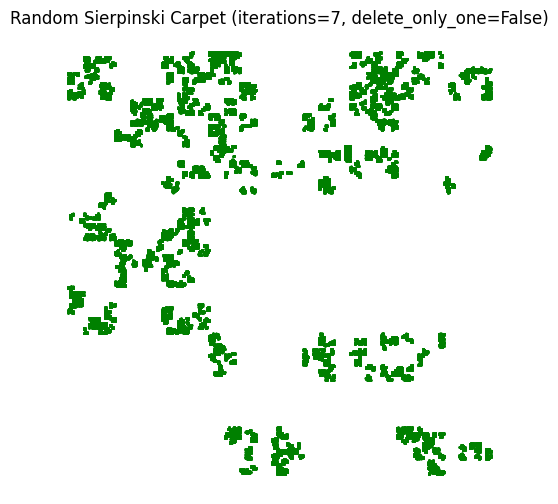

Box-counting dimension: 1.3700


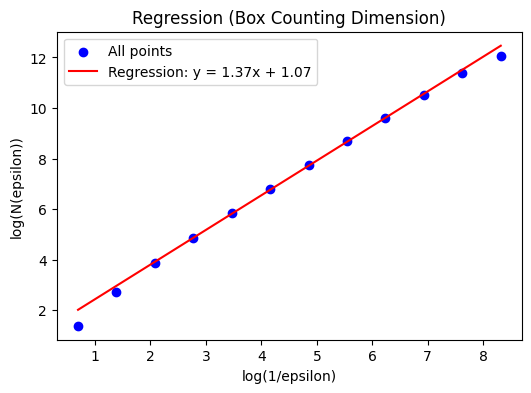

In [39]:
for i in range(1, 5):
    iterations = 7
    num_points=10000000
    pts = draw_sierpinski_carpet_mod_rand_points(iterations, True, False, math.ceil(num_points/math.pow(8,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)

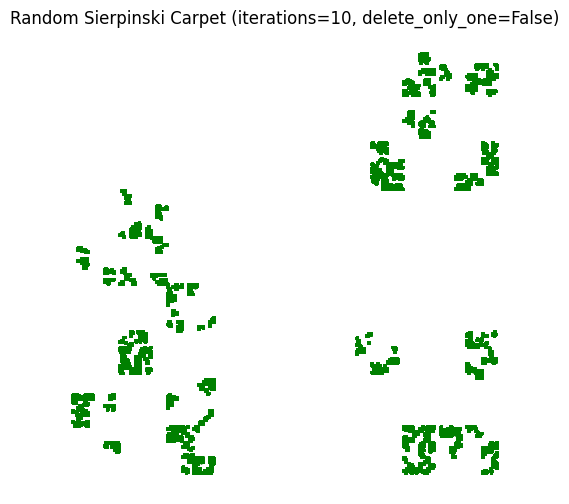

Box-counting dimension: 1.3543


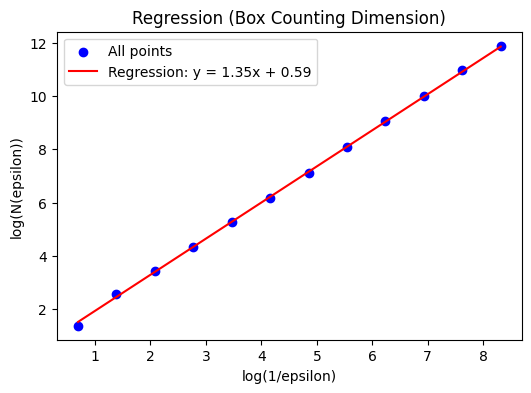

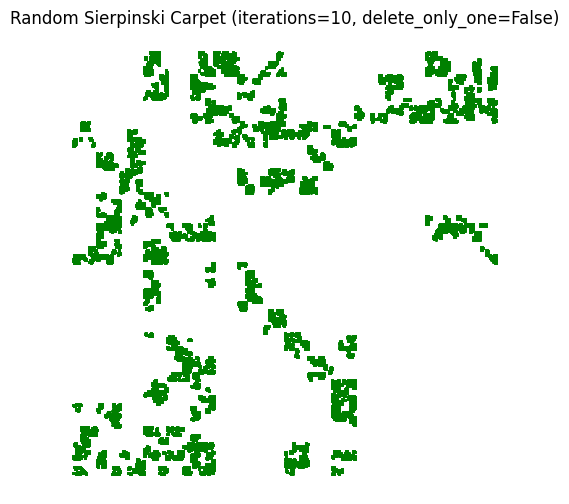

Box-counting dimension: 1.4146


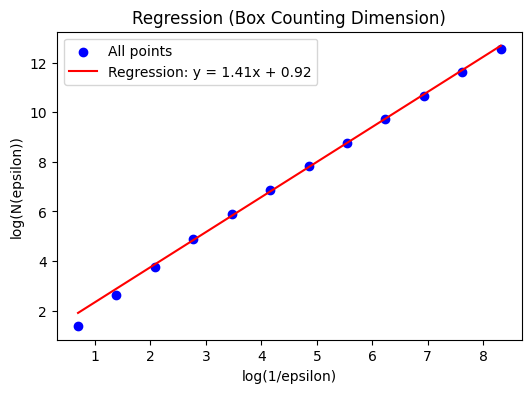

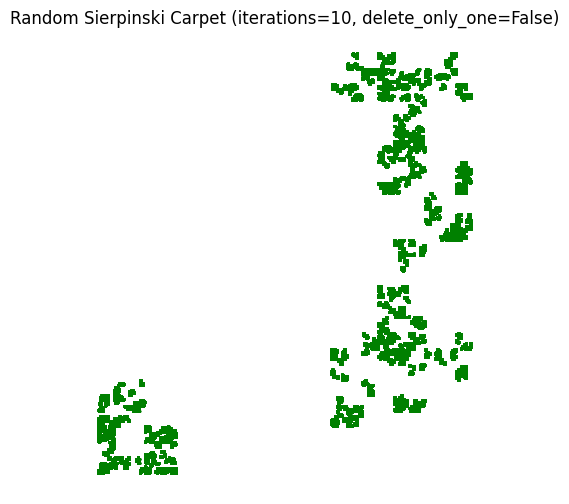

Box-counting dimension: 1.4754


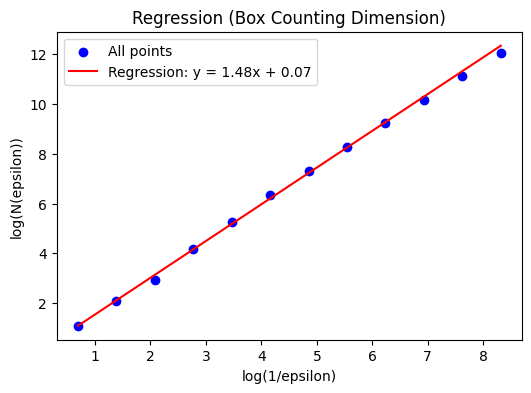

In [9]:
for i in range(1, 4):
    iterations = 10
    num_points=10000000
    pts = draw_sierpinski_carpet_mod_rand_points(iterations, True, False, math.ceil(num_points/math.pow(8,iterations)))
    show_results_2d(pts, epsilons=None, skip_extremes=2)